# Import Packages

---



In [0]:
!pip install -q livelossplot

In [2]:
# base
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
from matplotlib import style
style.use('seaborn-pastel')
from tqdm import tqdm_notebook
import pickle
import random

# keras or scikit
import keras
from keras.layers import Dense, Dropout, Flatten, ReLU, LeakyReLU, Conv2D
from keras.models import Sequential, load_model, Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from livelossplot.keras import PlotLossesCallback

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

# prepare env
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)




Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


for load test set


In [3]:
!git clone https://github.com/malborroni/Emojis-from-emotions.git

Cloning into 'Emojis-from-emotions'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 2694 (delta 14), reused 23 (delta 6), pack-reused 2647
Receiving objects: 100% (2694/2694), 327.76 MiB | 37.63 MiB/s, done.
Resolving deltas: 100% (375/375), done.
Checking out files: 100% (1956/1956), done.


In [0]:
def model_plot(history):
  fig, axes = plt.subplots(1, 2, figsize = (20, 5))
  colors = ['lightsalmon', 'lightblue']

  axes[0].set_title('Model Loss')
  axes[0].plot(history['loss'], color = colors[0])
  axes[0].plot(history['val_loss'], color = colors[1])
  
  axes[0].set_ylabel('Loss')
  axes[0].set_xlabel('Epoch')
  axes[0].legend(['train', 'val'], loc='upper right')

  axes[1].set_title('Model Accuracy')
  axes[1].plot(history['acc'], color = colors[0])
  axes[1].plot(history['val_acc'], color = colors[1])
  
  axes[1].set_ylabel('Accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(['train', 'val'], loc='upper left')

In [0]:
with np.load('/content/gdrive/My Drive/extracted_3fold1.npz') as data:
  # training set
  x_train1 = data['x_train1']
  y_train1 = data['y_train1']

  # validation set
  x_val1 = data['x_val1']
  y_val1 = data['y_val1']

  # test set
  x_test1 = data['x_test1']
  y_test1 = data['y_test1']

In [0]:
x_train = np.append(np.array(x_train1),x_val1,axis=0)
del x_train1, x_val1
x_train = np.append(np.array(x_train),x_test1,axis=0)
del x_test1

y_train = np.append(np.array(y_train1),y_val1,axis=0)
y_train = np.append(np.array(y_train),y_test1,axis=0)
del y_test1, y_train1, y_val1

In [7]:
x_train.shape, y_train.shape

((6472, 14, 14, 1024), (6472,))

In [10]:
path = '/content/Emojis-from-emotions/images/test'

test = []
labels = []
for label in os.listdir(path):
  for image in os.listdir(path+'/'+label):
    test.append(cv.imread(os.path.join(path+'/'+label, image)))
    labels.append(label)


x_test = np.array(test)
y_test = np.array(labels)

x_test.shape, y_test.shape

((118, 224, 224, 3), (118,))

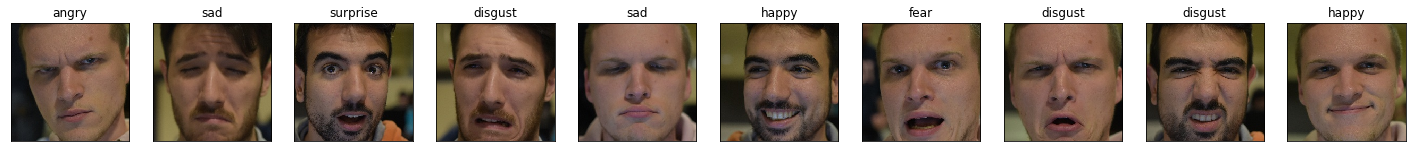

In [11]:
plt.figure(figsize=(25, 8))
nimages = 10 
for i in range(nimages):
    ax = plt.subplot(2, nimages, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    l = random.randint(0, len(labels))
    plt.imshow(cv.cvtColor(x_test[l], cv.COLOR_BGR2RGB))
    plt.title(str(y_test[l]))

# Preprocessing

---



In [0]:
le = LabelEncoder()

In [0]:
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes = 7)

In [0]:
y_test = le.fit_transform(y_test)
y_test = to_categorical(y_test, num_classes = 7)

In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-lterfip0
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-lterfip0
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=390b257cb56958abb2e5bcd3fc694d9a4836862a5b2199686ca913507e405f59
  Stored in directory: /tmp/pip-ephem-wheel-cache-a0ltb0ke/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

In [0]:
x_test = x_test.astype('float64')
x_test = preprocess_input(x_test, version=2)

In [0]:
K.clear_session()
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')
# Creazione del modello con output al layer scelto nel progetto come migliore
model = Model(inputs=base_model.input, outputs=base_model.get_layer("activation_51").output)















104947712/104944616 [==============================] - 1s 0us/step


In [0]:
x_test = model.predict(preprocess_input(x_test.astype('float64'),version=2)).astype('float32')

In [0]:
print('Shape del training set: {} --- {}\nShape del test set: {} --- {}'. format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

Shape del training set: (6472, 14, 14, 1024) --- (6472, 7)
Shape del test set: (105, 14, 14, 1024) --- (105, 7)


# Modello

---



In [0]:
def create_model():
  K.clear_session()
  # Create model
  model = Sequential()

  filters = 191
  size_filters = 4
  # C1
  model.add(Conv2D(filters, kernel_size=size_filters, input_shape=(14, 14, 1024)))
  model.add(LeakyReLU())
  model.add(Conv2D(filters, kernel_size=size_filters))
  model.add(LeakyReLU())
  model.add(Conv2D(filters, kernel_size=size_filters))
  model.add(LeakyReLU())
  # flat
  model.add(Flatten())
  # D1
  model.add(Dense(346, kernel_regularizer=regularizers.l2(0.01)))
  model.add(LeakyReLU()) 
  model.add(Dropout(0.5))
  
  # output  
  model.add(Dense(7, activation='softmax'))

  # Compile model
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1.364710328809509e-05),
              metrics=['acc'])
  
  return model

# Training 

---



In [0]:
# config model
batch_size = 128
num_epoch = 200
# callbacks
filepath = "/content/gdrive/My Drive/Colab Notebooks/AML/model_final/CNN_opt.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1,restore_best_weights=False) 
callbacks_list = [early_stop, checkpoint, PlotLossesCallback()]

In [0]:
model = create_model()

history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = num_epoch,
                    callbacks = callbacks_list,
                    verbose = 1,
                    validation_split = .1)

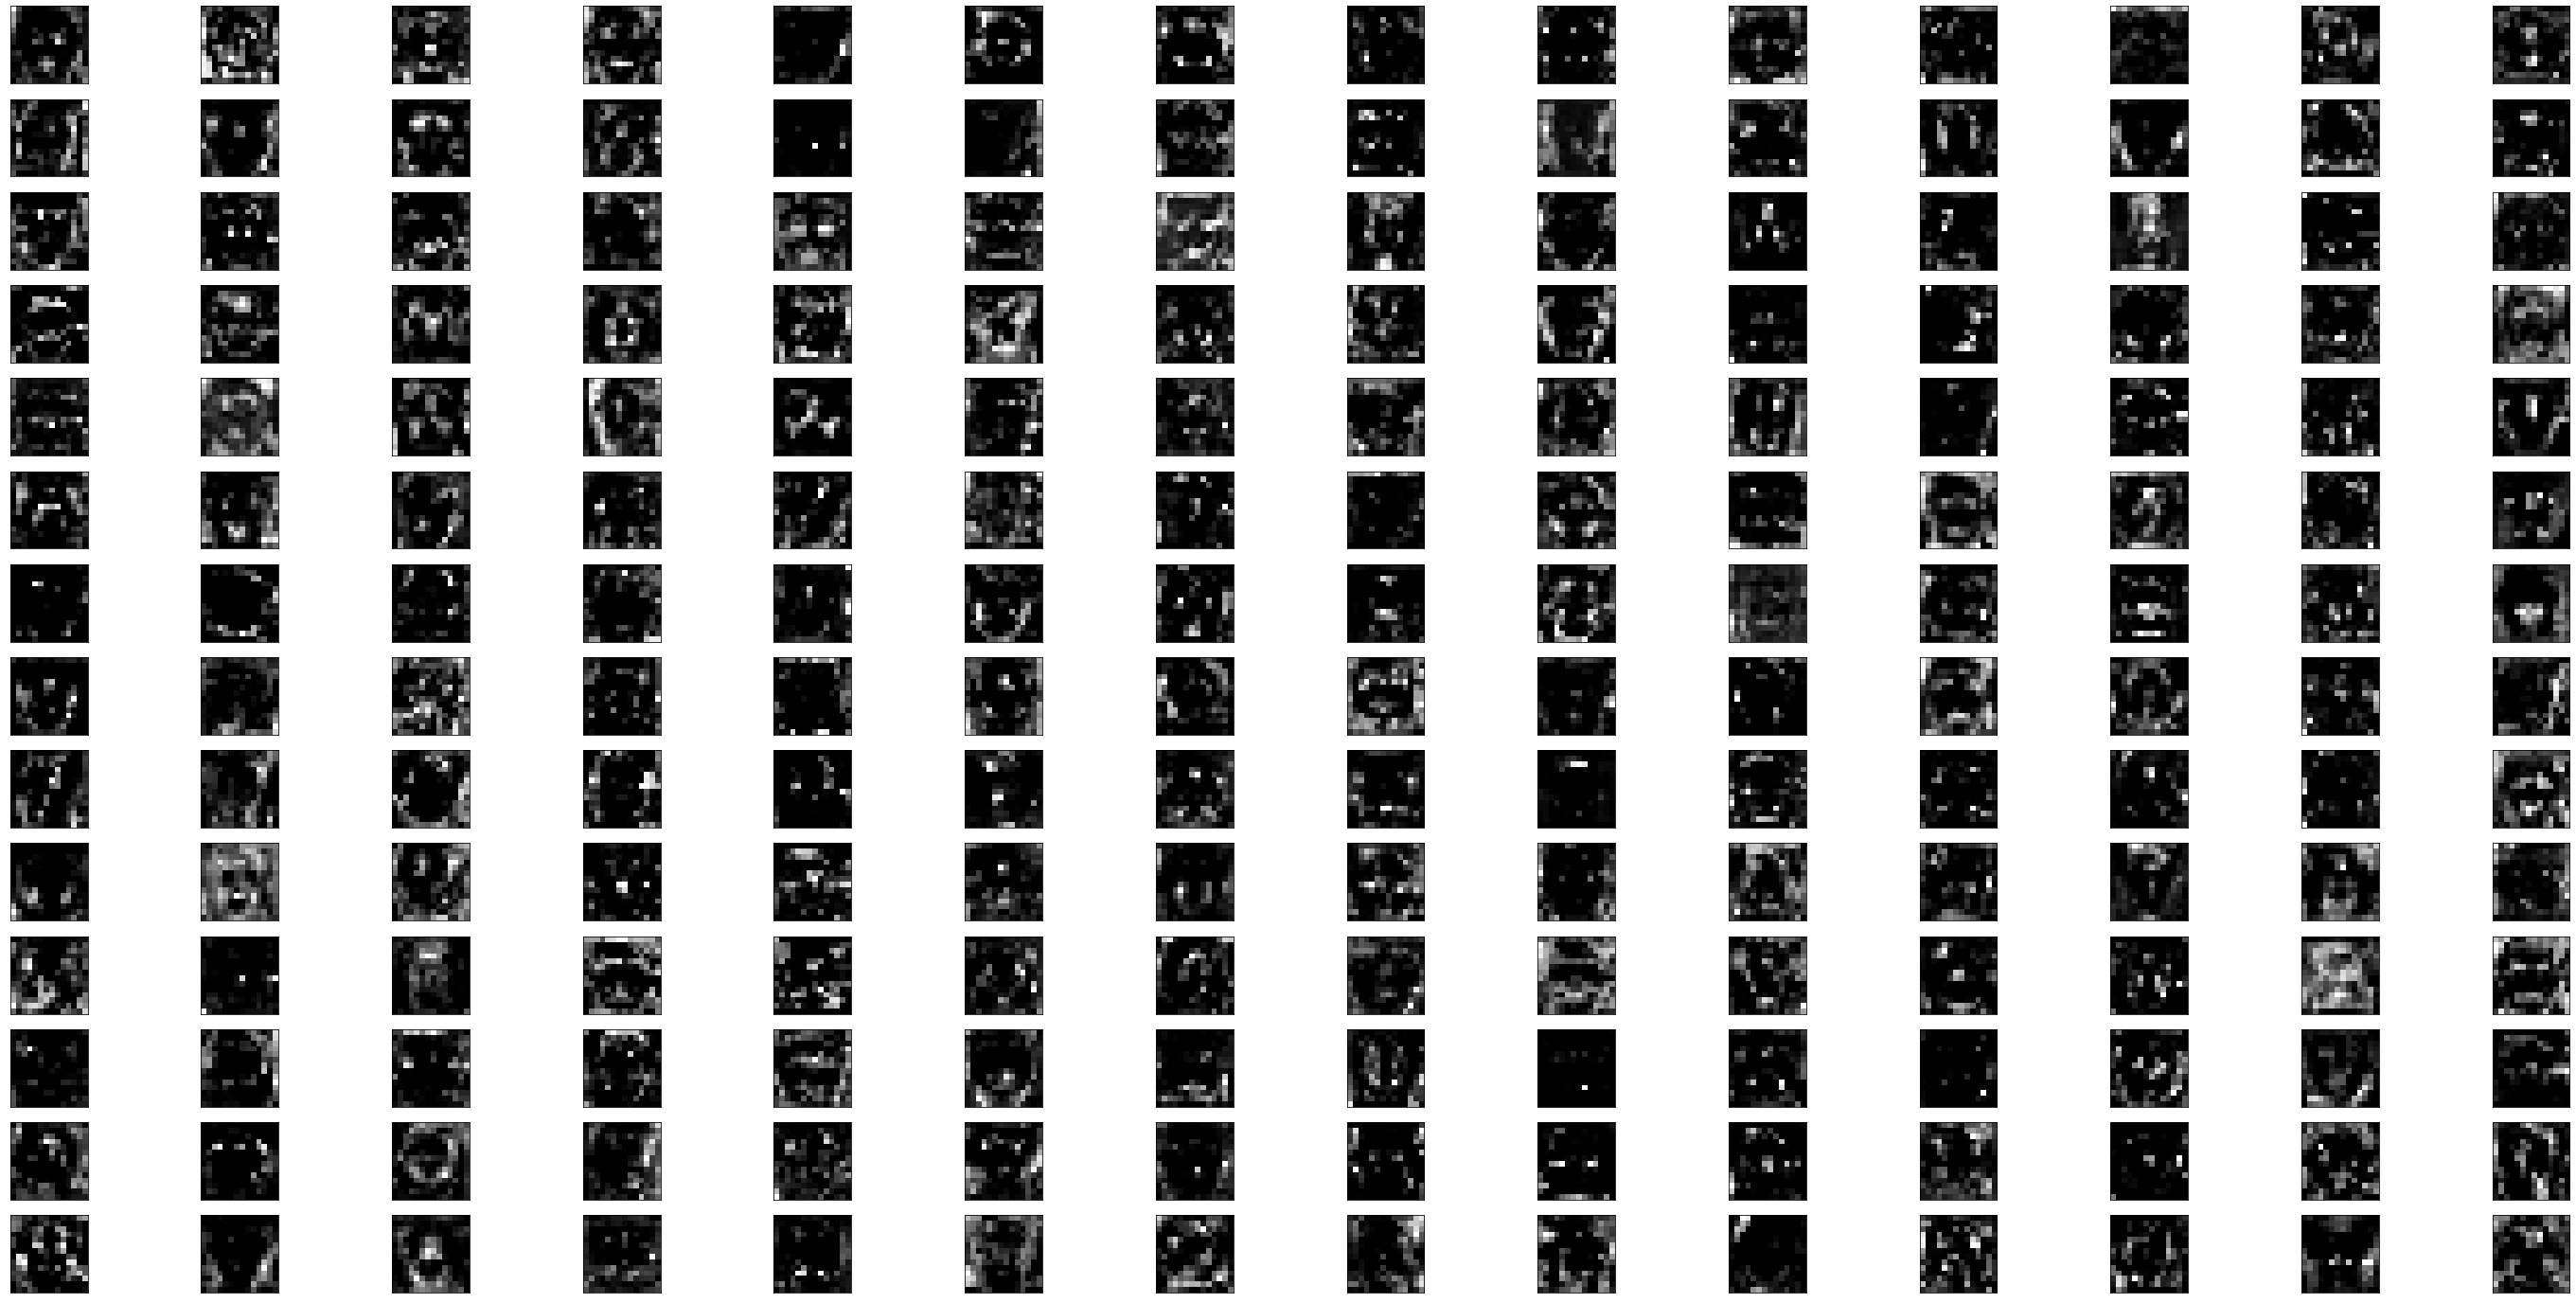

In [0]:
#feature_maps = model.predict(test)
# plot the output from each block
plt.figure(figsize=(50, 25))
square = 14
for fmap in x_test[-1:]:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[:, :, ix-1], cmap='gray')
			ix += 1
	# show the figure

	plt.show()